<a name="intro"></a>

# Notebook 4: Análisis del Modelo de Random Forest (RF)

## Introducción

El enfoque de este notebook está en el algoritmo de Random Forest, un método de aprendizaje conjunto que opera construyendo una multitud de árboles de decisión durante el entrenamiento y produciendo la clase que es la moda de las clases (clasificación) o la predicción media (regresión) de los árboles individuales.

Aplicaremos el algoritmo de Random Forest a nuestro conjunto de datos de la bomba de agua, con el objetivo de predecir el rendimiento de la bomba basado en las características de entrada. Después, calcularemos la imporancia de cada variable usando el método de SHAP, el cual se puede usar con con cualquier modelo, y el método MDI, que es propio de los RFs.

Los resultados serán luego comparados con los resultados de otras técnicas de modelado en el Notebook 6.


<a name="indice"></a>
# Índice

*   [Introducción](#intro)

*   [Libraries](#librerias)

*   [Preparación de los datos](#readingdata)

  - [Carga del conjunto de datos](#cargardatos)
  - [Conjuntos de entrenamiento y prueba](#limpiardatos)  

*   [Modelo de RF](#modeloredes)

  - [Definición del modelo](#definicionmodelos)
  - [Entrenamiento del modelo](#entrenamientomodelos)
  - [Evaluación del modelo](#evaluacionmodelos)
  - [Importancia de las variables (MDI)](#importanciamdi)
  - [Importancia de las variables (SHAP)](#importanciavariables)
  

*   [Guardando los resultados](#guardar)

<a name="librerias"></a>

## Librerias

[Keras](https://es.wikipedia.org/wiki/Keras) es una API de redes neuronales de alto nivel que puede ejecutarse sobre [Tensorflow](https://es.wikipedia.org/wiki/TensorFlow), lo que permite el prototipado fácil y rápido de modelos de aprendizaje profundo. TensorFlow, desarrollado por el equipo de Google Brain, es una plataforma de código abierto de extremo a extremo para el aprendizaje automático que proporciona un ecosistema integral de herramientas y bibliotecas para construir y desplegar aplicaciones impulsadas por el aprendizaje automático.

[Numpy](https://es.wikipedia.org/wiki/NumPy) es un paquete fundamental para la computación científica en Python, que proporciona soporte para matrices y arreglos multidimensionales de gran tamaño, junto con una colección de funciones matemáticas para operar eficientemente en estos arreglos.

[Pandas](https://es.wikipedia.org/wiki/Pandas_(software)) es una biblioteca que ofrece estructuras de datos y herramientas de análisis de datos de alto rendimiento y fáciles de usar para Python. Su estructura de datos principal es el DataFrame, que permite almacenar y manipular datos tabulares en filas de observaciones y columnas de variables.

[Matplotlib](https://es.wikipedia.org/wiki/Matplotlib) es una biblioteca de trazado de gráficos para Python y su extensión matemática numérica, NumPy. Proporciona una API orientada a objetos para incrustar gráficos en aplicaciones utilizando herramientas de interfaz gráfica de usuario de propósito general como Tkinter, wxPython, Qt o GTK.

El módulo "random" implementa generadores de números pseudoaleatorios para diversas distribuciones y es útil para tareas como la selección aleatoria de muestras y la elección de elementos aleatorios de un rango o colección.

[Scikit-learn](https://en.wikipedia.org/wiki/Scikit-learn) (Sklearn) es una biblioteca de aprendizaje automático para Python que proporciona herramientas simples y eficientes para la minería de datos y el análisis de datos. Cuenta con varios algoritmos de clasificación, regresión y agrupamiento.

[SHAP](https://shap.readthedocs.io/en/latest/index.html) (SHapley Additive exPlanations) es una biblioteca que explica la salida de los modelos de aprendizaje automático mediante el cálculo de la contribución de cada característica a la predicción.

Google Colab es un servicio en la nube gratuito basado en Jupyter Notebooks que admite GPU gratuitas e integra con Google Drive. Se utiliza para la educación e investigación en aprendizaje automático, proporcionando un entorno fácil de usar para escribir y ejecutar código Python, lo cual es especialmente beneficioso para proyectos colaborativos.

In [1]:
# Librerias generales
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para trabajar con números aleatorios
import random

# Curvas ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Otras librerias auxiliares de scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Importamos las librerías para trabjar con PLS y varias funciones de estadística
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from zmq import NULL

# Librerias para el Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import accuracy_score,classification_report,confusion_matrix
import joblib

# Librería SHAP
!pip install shap # Esta librería no está instalada por defecto en Google,
                  # con este código se instala en la sesión
import shap

# Libreria para el uso de archivos
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.3 MB/s eta 0:00:00


[(*volver al índice*)](#indice)

<a name="readingdata"></a>
# Preparado de datos

<a name="cargardatos"></a>
## Cargar el conjunto de datos

Cargamos los datos en memoria y comprobamos que todo funciona. Los datos ya están balanceados por el código anterior disponible en el Notebook 0.

La primera vez que te conectas el drive de Google te pide permiso para acceder y tienes que pinchar en aceptar dicho permiso.

In [13]:
# Nombre del archivos con las X e Ys
X_FILE_NAME = "Datos_balanceados_X_6000.txt"
Y_FILE_NAME = "Datos_balanceados_Y_6000.txt"
X_FILE_NAME = "Datos_balanceados_X_500.txt"
Y_FILE_NAME = "Datos_balanceados_Y_500.txt"

# Nombre de los directorios con los ficheros
PROJECT_FOLDER = "/content/drive/My Drive/Colab Notebooks/"
DATA_FOLDER    = "/Resultados/Balanceo de datos/"

# Montar el disco de drive
drive.mount('/content/drive')

# Guardamos el ID de cada sensor; notice that ID 15 is not in the list
sensorNames = ["SENSOR_00", "SENSOR_01", "SENSOR_02", "SENSOR_03", "SENSOR_04",
               "SENSOR_05", "SENSOR_06", "SENSOR_07", "SENSOR_08", "SENSOR_09",
               "SENSOR_10", "SENSOR_11", "SENSOR_12", "SENSOR_13", "SENSOR_14",
               "SENSOR_16", "SENSOR_17", "SENSOR_18", "SENSOR_19", "SENSOR_20",
               "SENSOR_21", "SENSOR_22", "SENSOR_23", "SENSOR_24", "SENSOR_25",
               "SENSOR_26", "SENSOR_27", "SENSOR_28", "SENSOR_29", "SENSOR_30",
               "SENSOR_31", "SENSOR_32", "SENSOR_33", "SENSOR_34", "SENSOR_35",
               "SENSOR_36", "SENSOR_37", "SENSOR_38", "SENSOR_39", "SENSOR_40",
               "SENSOR_41", "SENSOR_42", "SENSOR_43", "SENSOR_44", "SENSOR_45",
               "SENSOR_46", "SENSOR_47", "SENSOR_48", "SENSOR_49", "SENSOR_50",
               "SENSOR_51"]

# Guardamos el significado de cada sensor
sensorProperties = ["Motor Casing Vibration", "Motor Frequency A",
                    "Motor Frequency B", "Motor Frequency C", "Motor Speed",
                    "Motor Current", "Motor Active Power",
                    "Motor Apparent Power", "Motor Reactive Power",
                    "Motor Shaft Power", "Motor Phase Current A",
                    "Motor Phase Current B", "Motor Phase Current C",
                    "Motor Coupling Vibration", "Motor Phase Voltage AB",
                    "Motor Phase Voltage BC", "Motor Phase Voltage CA",
                    "Pump Casing Vibration", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Inlet Flow", "Pump Discharge Flow", "Pump UNKNOWN",
                    "Pump Lube Oil Overhead Reservoir Level",
                    "Pump Lube Oil Return Temp", "Pump Lube Oil Supply Temp",
                    "Pump Thrust Bearing Active Temp",
                    "Motor Non Drive End Radial Bearing Temp 1",
                    "Motor Non Drive End Radial Bearing Temp 2",
                    "Pump Thrust Bearing Inactive Temp",
                    "Pump Drive End Radial Bearing Temp 1",
                    "Pump non Drive End Radial Bearing Temp 1",
                    "Pump Non Drive End Radial Bearing Temp 2",
                    "Pump Drive End Radial Bearing Temp 2",
                    "Pump Inlet Pressure", "Pump Temp Unknown",
                    "Pump Discharge Pressure 1", "Pump Discharge Pressure 2"]

# Recordamos que eliminamos los datos de los sensores 15 y 50. Así que
# procedemos a eliminar también los nombres de estas listas
#
# Pero el sensor 15, NO ESTÁ EN LA LISTA.
# Sólo quitamos el 50, que corresponde con la posición 49 (vaya lío)
del sensorProperties[49]
del sensorNames[49]

# Cárgamos el archivo en un dataframe
# NOTA: La columna para el sensor 15 está vacía, esto es correcto
data_x = pd.read_csv( PROJECT_FOLDER + DATA_FOLDER + X_FILE_NAME, sep = " ", header=None)
data_y = pd.read_csv( PROJECT_FOLDER + DATA_FOLDER + Y_FILE_NAME, sep = " ", header=None)
data_y = data_y.astype(int)

# Renombramos los nombres de las columnas para mayor claridad
data_x.columns = sensorNames
data_y.columns = ["Y"]

print("Cargado de datos concluido")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargado de datos concluido


[(*volver al índice*)](#indice)

<a name="limpiardatos"></a>
## Conjunto de entramiento y test de datos

Dividimos el conjunto de los 6000 datos en entrenamiento y test con una proporción del 80%, de tal forma que el conjunto de entrenamiento tendrá unos 4800 datos y el de test alrededor de 1200.

In [14]:
# Semilla aleatoria constante para reproducibilidad
RANDOM_SEED = 42

# Declaramos la proporción de datos que son para entrenar y para testear
TRAIN_PROPORTION = 0.8 # Esto significa el 80% de los datos para el conjunto
                       # de entrenamiento y el 20% para el conjunto test

# Separamos los datos en conjunto de entrenamiento y datos:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_x, data_y, test_size = (1 - TRAIN_PROPORTION), random_state = RANDOM_SEED)

# Los convertimos de vuelta a dataframes
Xtrain = pd.DataFrame(Xtrain, columns=data_x.columns)
Xtest  = pd.DataFrame(Xtest,  columns=data_x.columns)
Ytrain = pd.DataFrame(Ytrain, columns=data_y.columns)
Ytest  = pd.DataFrame(Ytest,  columns=data_y.columns)

# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = Xtrain.shape[0]
totalInputsColumns = Xtrain.shape[1]

[(*volver al índice*)](#indice)

<a name="randomforest"></a>
# Random Forest

Un árbol de decisión sobre un conjunto de datos corre el riesgo de hacer overfitting y que no sirva para datos nuevos. Para solucionar eso, se usa el modelo de random forest por mediante el cual se generan muchos árboles de decisión donde cada uno se ha entrenado con un sub-conjunto aleatorio del conjunto de datos total. Cada uno de los árboles da una solución posible y se selecciona la mejor mediante concenso.

Vídeo de introducción https://www.youtube.com/watch?v=GOJg3EE-nDM

Los random forest tienen la ventaja de ser un clasificador que funciona tanto para variables continuas como para variables discretas. Es un modelo robusto que soporta bien los datos con ruido y tiene una gran fiabilidad. Se distingue principalmente del resto de modelos en que tiene la mejor solución al problema de extración de importancia de variables.

Como contrapartida, aunque un random forest es mucho mejor que un árbol de decisión, tiende también al overfitting. Es difícil de interpretar dado que tienes que seguir no sólo un árbol de decisión si no varios a la vez. Y es computacionalmente muy costoso de entrenar tando en CPU como en memoria.

In [15]:
randomforest = RandomForestClassifier(criterion='entropy')
randomforest.fit(Xtrain,Ytrain.squeeze())

y_predict = randomforest.predict(Xtest)

print(accuracy_score(Ytest.squeeze(),y_predict))

0.995049504950495


<a name="importanciamdi"></a>
## Importancia de cada variable (MDI).

La disminución media de las impurezas (Mean Decrease of Impurity, MDI) [ https://doi.org/10.1023/a:1010933404324] es una medida utilizada en bosques aleatorios para cuantificar la importancia de cada característica en la predicción de una variable objetivo. Se calcula el MDI midiendo la importancia de cada variable, en cada árbol, y calculando cómo Se reduce la impureza. Cuando se utiliza una variable para dividir un nodo de árbol, se reduce la impureza de ese nodo, y la reducción de la impureza se correlaciona con la importancia de esa variable. El MDI de una característica se calcula promediando la reducción de impurezas en todos los árboles en los que se utiliza esa característica. Un MDI más alto significa más importancia.

In [16]:
# Los valores MDI no dependen de ninguna simulación. Son únicos para el modelo y
# es una de las ventajas del Random Forest. Es muy fácil de explicar, pero suele
# ser peor en predicciones, o bien ser más sesgado en las predicciones.

# Creamos un vector donde almacenamos los valores MDI para cada uno de los sensores
vectorMediasMDI    = randomforest.feature_importances_
vectorAbsMediasMDI = randomforest.feature_importances_
vectorSigmasMDI    = np.zeros(50)
vectorAbsSigmasMDI = np.zeros(50)



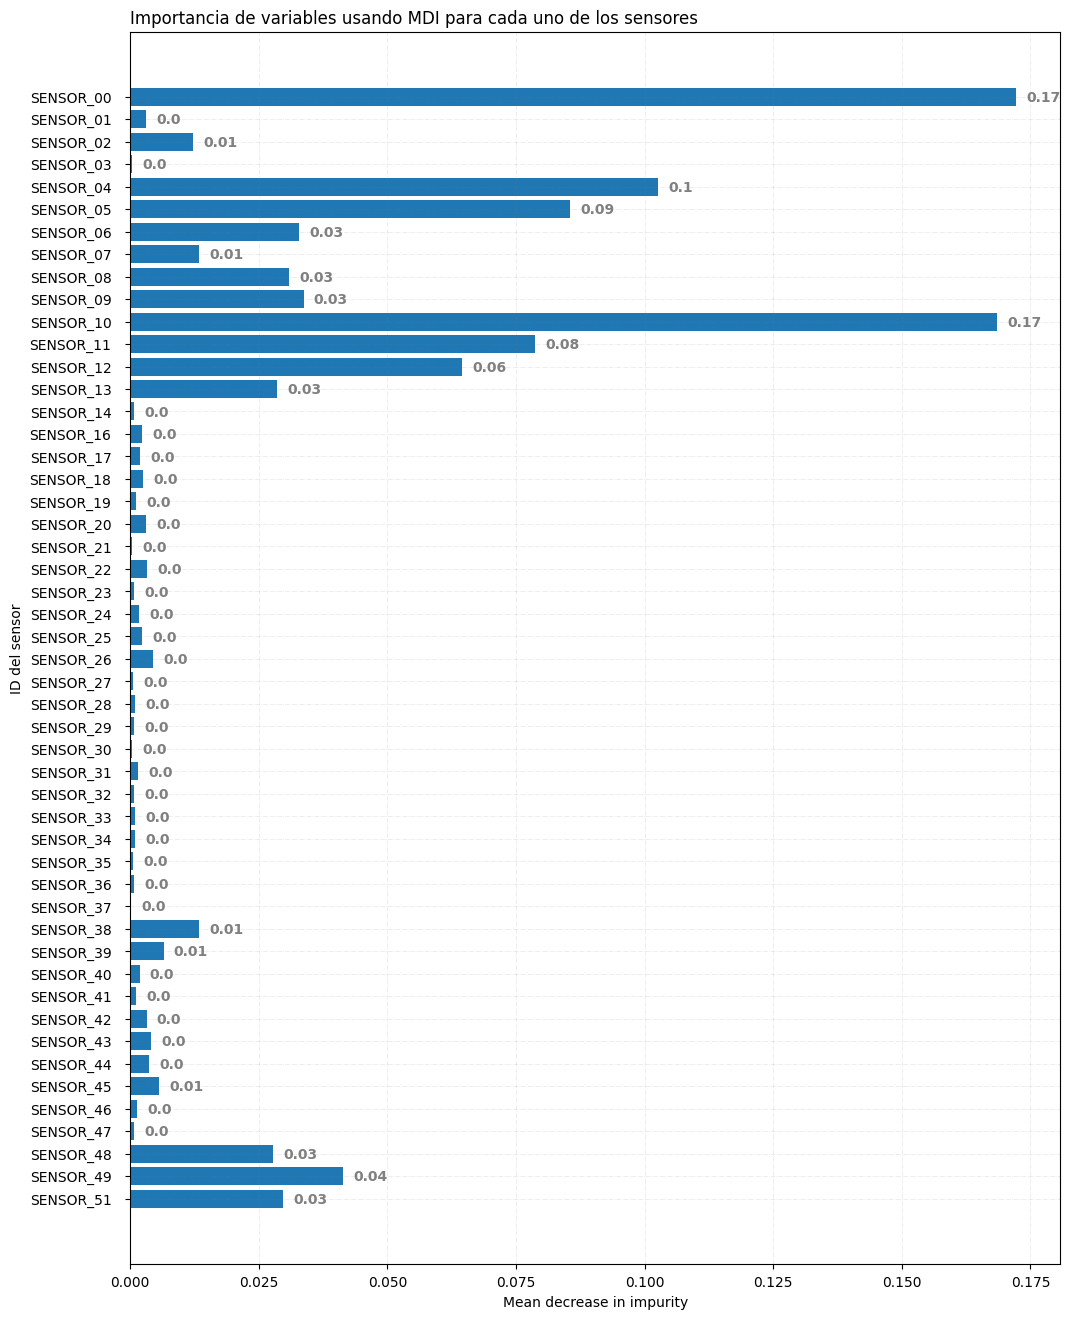

In [17]:
barplotData = pd.DataFrame( np.zeros([len(vectorAbsMediasMDI),2]) )
barplotData[0] = data_x.columns
barplotData[1] = vectorAbsMediasMDI

# Figure Size
fig, ax = plt.subplots(figsize=(12, 16))

# Horizontal Bar Plot
plt.barh(barplotData[0], barplotData[1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

    currentOffset = 0.002
    currentW = i.get_width()
    if(currentW < 0): currentOffset = -0.005

    plt.text(i.get_width() + currentOffset, i.get_y() + 0.6,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Importancia de variables usando MDI para cada uno de los sensores',
             loc='left', )

ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("ID del sensor")

# Show Plot
plt.show()

<a name="importanciavariables"></a>
## Importancia de cada variable.

SHapley Additive exPlanations (SHAP) calcula los valores de Shapley, que es un concepto de la Teoría de Juegos Cooperativos, para explicar la contribución de cada uno de los característica de entrada a la predicción final del modelo. SHAP se puede utilizar en cualquier algoritmo de aprendizaje y es fácil de interpretar, pero requiere un gran número de muestras para capturar adecuadamente las interacciones de las variables lo que es computacionalmente costoso.

Como regla general, los modelos que son difíciles de interpretar, como las redes neuronales, son mejores prediciendo resultados. Y los modelos que son más fáciles de interpretar, como los random forests, tienden más al sobreajuste o son peores prediciendo el resultado final.

In [18]:
# No hace falta declarar ningún tamaño de muestra para SHAP. En el caso de los
# RF esto es muy fácil de calcular y tarda unos 30s en hacerlo. Se haran todas
# las muestras del conjunto de test que son unas 1200 aproximadamente.

# ---- Se hacen las predicciones.
explainerRF   = shap.Explainer(randomforest, Xtrain)
shap_valuesRF = explainerRF(Xtest, check_additivity=False)

In [19]:
# Extraemos los elementos izquierdos y derechos de los valores SHAPs
# (el shap para el random forest es un tanto confuso)
left_list  = [[item[0] for item in sublist] for sublist in shap_valuesRF.values]
right_list = [[item[1] for item in sublist] for sublist in shap_valuesRF.values]

# Inicializamos el vector de base (todos los números son iguales)
base_data = np.random.rand(len(left_list))
for i in range(len(base_data)):
  base_data[i] = shap_valuesRF[0].base_values[0]

# Creamos varios vectores donde almacenamos los valores SHAP

vectorSHAP_valores = left_list
vectorSHAP_base    = base_data
vectorSHAP_data    = shap_valuesRF.data

# Guardamos también varios valores de medias y desviaciones típicas que usaremos
# en el mapa de calor final.

vectorMediasSHAP    = np.mean(vectorSHAP_valores,              axis=0)
vectorAbsMediasSHAP = np.mean(np.absolute(vectorSHAP_valores), axis=0)
vectorSigmasSHAP    = np.std( vectorSHAP_valores,              axis=0)
vectorAbsSigmasSHAP = np.std( np.absolute(vectorSHAP_valores), axis=0)

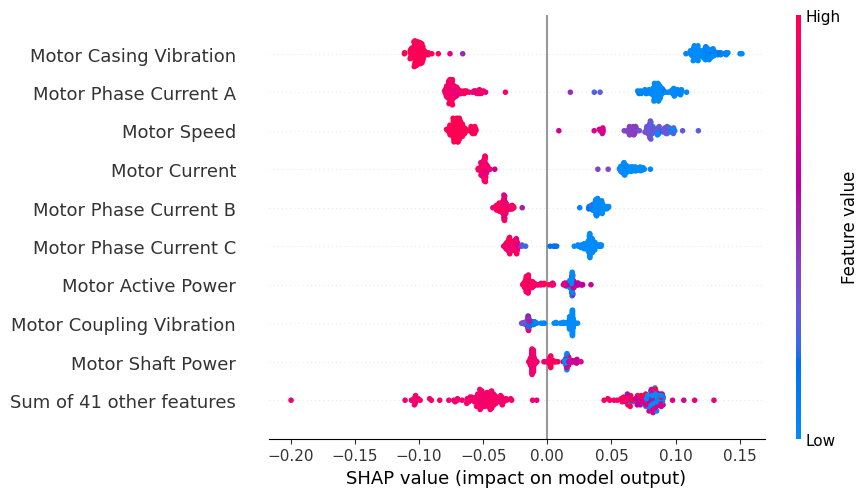

In [20]:
# Para poder hacer el beeswarm hay que hacer unas transformaciones un poco raras
# primero. Aquí simplemente convierto un objecto explanation del SHAP a otro
# objeto.
explanation4 = shap.Explanation(
    values        = vectorSHAP_valores,
    base_values   = vectorSHAP_base,
    data          = vectorSHAP_data,
    feature_names = sensorProperties
)

# Plots del beeswarm y violin
shap.plots.beeswarm(explanation4)
# shap.summary_plot(explanation4, plot_type='violin', max_display=10)
# Se niega a hacer el violinplot y no se porqué >:(

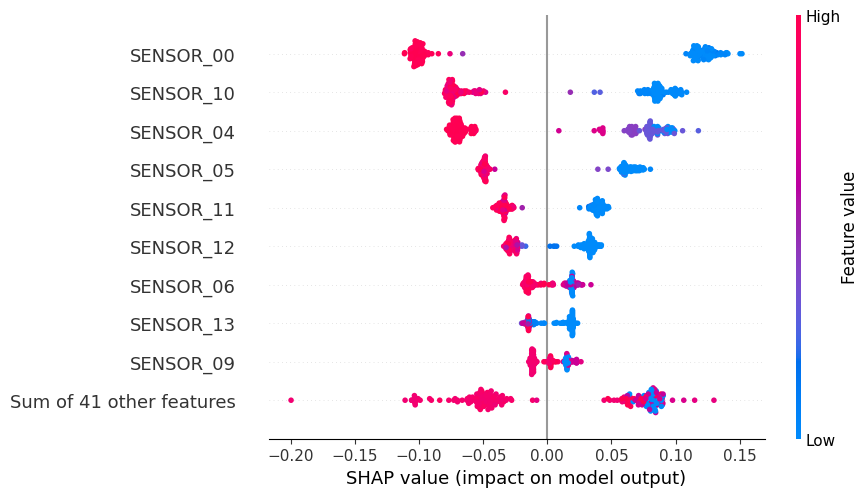

In [21]:
# Mismo código, pero para el ID en lugar de los nombres
explanation4 = shap.Explanation(
    values        = vectorSHAP_valores,
    base_values   = vectorSHAP_base,
    data          = vectorSHAP_data,
    feature_names = sensorNames
)

# Plots del beeswarm y violin
shap.plots.beeswarm(explanation4)

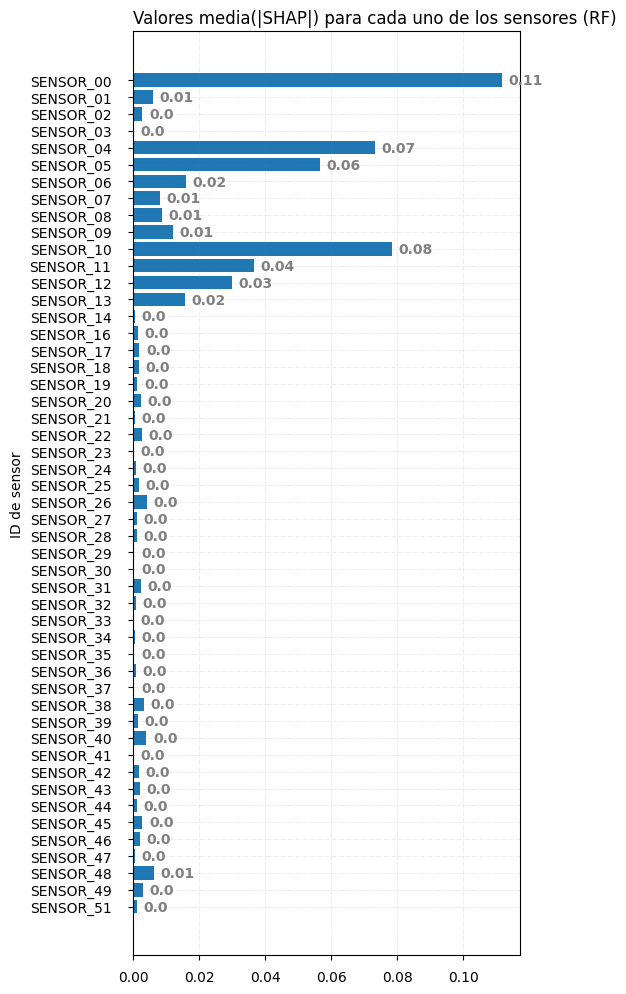

In [22]:
# Mostrar el gráfico

# Este comando es lo mismo, pero sólo muestra los 20 primeros, para mantener consistencia muestro los 50 sensores.
# shap.summary_plot( shap_values , mySamples, feature_names = list(Xtrain.columns) )

variablesNames = list(Xtrain.columns)
currentPlotTitle = 'Valores media(|SHAP|) para cada uno de los sensores (RF)'

# Create the plot dataframe
barplotData = pd.DataFrame( np.zeros([len(sensorNames),2]) , columns = ['name', 'value'] )
barplotData.iloc[:,0] = sensorNames
barplotData.iloc[:,1] = vectorAbsMediasSHAP

# Figure Size
fig, ax = plt.subplots(figsize=(5, 12))

# Horizontal Bar Plot
plt.barh(barplotData.iloc[:,0],  barplotData.iloc[:,1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=7)
ax.yaxis.set_tick_params(pad=12)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show first values on top
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

  currentOffset = 0.002
  currentW = i.get_width()
  if(currentW < 0): currentOffset = -0.005

  plt.text(i.get_width() + currentOffset, i.get_y() + 0.65,
           str(round((i.get_width()), 2)),
           fontsize=10, fontweight='bold',
           color='grey')


# Add Plot Title
ax.set_title(currentPlotTitle,loc='left', )
ax.set_ylabel("ID de sensor")

# Show Plot
plt.show()

<a name="guardar"></a>

## Guardado de resultados

En esta sección guardamos todos los resultados y logs en la carpeta de Resultados/RF del drive.

In [23]:
# ------------------------------------------------------------------------------
# Valores medios absolutos y similares
# ------------------------------------------------------------------------------

# Nombre del fichero y directorio donde se guarda
BASE_FOLDER = PROJECT_FOLDER + 'Resultados/RF/'
RF_MDI_WEIGHTS  = 'RF_MDI_500.csv'
RF_SHAP_WEIGHTS = 'RF_SHAP_500.csv'


# Se convierten los resultados a un dataframe
RF_MDI_WEIGHTS_DF = pd.DataFrame({'Means':    np.squeeze(vectorMediasMDI),
                                  'AbsMeans': np.squeeze(vectorAbsMediasMDI),
                                  'Sigma':    np.squeeze(vectorSigmasMDI),
                                  'AbsSigma': np.squeeze(vectorAbsSigmasMDI)})

RF_SHAP_WEIGHTS_DF = pd.DataFrame({'Means':    np.squeeze(vectorMediasSHAP),
                                   'AbsMeans': np.squeeze(vectorAbsMediasSHAP),
                                   'Sigma':    np.squeeze(vectorSigmasSHAP),
                                   'AbsSigma': np.squeeze(vectorAbsSigmasSHAP)})

# Guardar el resultado para que luego se pueda hacer el heatmap
RF_MDI_WEIGHTS_DF.to_csv(  BASE_FOLDER + RF_MDI_WEIGHTS,  index=False)
RF_SHAP_WEIGHTS_DF.to_csv( BASE_FOLDER + RF_SHAP_WEIGHTS, index=False)

# ------------------------------------------------------------------------------
# Valores del Explainer
# ------------------------------------------------------------------------------

# Guardamos los valores del objecto Explainer por si queremos modificar los
# gráficos luego o hacer otra cosa sin tener que esperar 2h a que se vuelvan
# a calcular
RF_EXPLANATION_VALUES      = 'explanationValues_500.txt'
RF_EXPLANATION_BASE_VALUES = 'explanationBase_500.txt'
RF_EXPLANATION_DATA        = 'explanationData_500.txt'
RF_EXPLANATION_FEATURES    = 'explanationFeatures_500.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Datos completos de SHAP/RF/'

np.savetxt(BASE_FOLDER + RF_EXPLANATION_VALUES,      vectorSHAP_valores)
np.savetxt(BASE_FOLDER + RF_EXPLANATION_BASE_VALUES, vectorSHAP_base)
np.savetxt(BASE_FOLDER + RF_EXPLANATION_DATA,        vectorSHAP_data)
np.savetxt(BASE_FOLDER + RF_EXPLANATION_FEATURES,    sensorNames,     fmt='%s')

# ------------------------------------------------------------------------------
# Modelo RF
# ------------------------------------------------------------------------------
BASE_FOLDER  = PROJECT_FOLDER + 'Resultados/RF/'
MODEL_FOLDER = BASE_FOLDER + 'Modelo/'
MODEL_NAME   = 'randomforest_model_500.pkl'

# Guardar en el drive
joblib.dump(randomforest, MODEL_FOLDER + MODEL_NAME)

['/content/drive/My Drive/Colab Notebooks/Resultados/RF/Modelo/randomforest_model_500.pkl']